In [1]:
import pandas as pd 
import numpy as np 

In [2]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
from data_clean_for_model import data_clean_for_model

In [4]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 50)
np.set_printoptions(suppress=True)

In [5]:
dfs = pd.read_parquet("data/all_processed_df.parquet.gzip")

In [6]:
k = 5
rseed=229
np.random.seed(rseed)
# add outcome var + unique id 
dfs['outcome'] = np.where(dfs['state']=="successful", 1, 0)
dfs['un_id'] = np.arange(0, dfs.shape[0], 1)
dfs['name_len'] = dfs['name'].str.len()
dfs['cv_group'] = np.random.choice(np.arange(0, k), size=dfs.shape[0])

In [7]:
dfs['binned_usd_goal'] = pd.qcut(np.log(dfs['usd_goal']+1), 20)

In [8]:
model_params = {
    'cv': True, 
    #'lnom_frac':0.3, 
    'test_frac':0.3, 
    'lnom_usdgoal':True,
    'dummies':True,
    'rseed': 229,
}
X_train, X_test, y_train, y_test = data_clean_for_model(dfs, "outcome", model_params, cv=model_params['cv'])

In [9]:
del dfs

In [10]:
id_vars = ["un_id", "cv_group"]
id_train = X_train[id_vars]
id_test = X_test[id_vars]
X_train = X_train.drop(columns=id_vars)
X_test = X_test.drop(columns=id_vars)

In [11]:
nb_proba_train = np.load("data/res/multi_nb_preds_train.npy")
nb_proba_test = np.load("data/res/multi_nb_preds_test.npy")
#nb_proba_train2 = np.load("data/res/multi_nb_preds_train_opt.npy")
#nb_proba_test2 = np.load("data/res/multi_nb_preds_test_opt.npy")
X_train_nb = X_train.copy()
X_test_nb = X_test.copy()
# NB 
X_train_nb['nb_proba'] = nb_proba_train[:, 1]
X_test_nb['nb_proba'] = nb_proba_test[:, 1]

In [12]:
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV

In [11]:
new_train_ind = int(X_test.shape[0]/3)
X_train_nb = pd.concat((X_train_nb, X_test_nb[0:new_train_ind])).reset_index(drop=True)
X_test_nb = X_test_nb[new_train_ind:].reset_index(drop=True)

y_train = pd.concat((y_train, y_test[0:new_train_ind])).reset_index(drop=True)
y_test = y_test[new_train_ind:].reset_index(drop=True)

X_train_nb.shape[0]/(X_train_nb.shape[0]+X_test_nb.shape[0])

0.7999981920740526

In [14]:
test_params = {'max_depth':55, 'num_leaves':400, 'max_bin':500, 'min_child_samples':100,'bagging_fraction':0.75, 'feature_fraction':0.2, 'lambda_l1':0, 'lambda_l2':0}
lgbmm = lgb.LGBMClassifier(random_state=rseed, verbose=-1, is_unbalance=True, **test_params)
lgbmm.fit(X_train_nb, y_train, 
      )
y = lgbmm.predict(X_test_nb)
(y==y_test).sum() / y.shape[0]

#0.82445197740113

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


0.8252806026365348

In [95]:
regularization_search_params = {
    'max_depth':[55],
    'num_leaves': [400], 
    'max_bin': [500], 
    #'min_child_samples': [100], 
    #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 10],
    'bagging_fraction': [0.75], 
    'feature_fraction': [0.2],
    #'lambda_l1': [0, 0.1, 1, 5, 10],
    'lambda_l2': [0, 0.1, 1, 5, 10],
    #'lambda_l2': [0, 0.1, 1, 5, 10]
    'lambda_l1': [0.1]
}

In [89]:
from sklearn.model_selection import StratifiedKFold, PredefinedSplit
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=229)

In [90]:
pf = PredefinedSplit(id_train['cv_group'])

In [96]:
lgbmm = lgb.LGBMClassifier(random_state=rseed, verbose=-1, is_unbalance=True)
gs_reg = GridSearchCV(
    estimator=lgbmm, 
    param_grid=regularization_search_params, 
    #n_iter=150,
    scoring='accuracy',
    refit=True,
    cv=pf,
    #random_state=rseed,
    n_jobs=4
)

In [97]:
gs_reg.fit(X_train_nb, y_train, 
       early_stopping_rounds=20, 
        eval_metric = 'binary', 
        eval_set = [(X_test_nb, y_test)],
        eval_names =['valid']
      )

[1]	valid's binary_logloss: 0.640472
Training until validation scores don't improve for 20 rounds
[2]	valid's binary_logloss: 0.606943
[3]	valid's binary_logloss: 0.592741
[4]	valid's binary_logloss: 0.561414
[5]	valid's binary_logloss: 0.548627
[6]	valid's binary_logloss: 0.526328
[7]	valid's binary_logloss: 0.509492
[8]	valid's binary_logloss: 0.497208
[9]	valid's binary_logloss: 0.484777
[10]	valid's binary_logloss: 0.469275
[11]	valid's binary_logloss: 0.461794
[12]	valid's binary_logloss: 0.451129
[13]	valid's binary_logloss: 0.441176
[14]	valid's binary_logloss: 0.4354
[15]	valid's binary_logloss: 0.430486
[16]	valid's binary_logloss: 0.425093
[17]	valid's binary_logloss: 0.419089
[18]	valid's binary_logloss: 0.414781
[19]	valid's binary_logloss: 0.409231
[20]	valid's binary_logloss: 0.403005
[21]	valid's binary_logloss: 0.39839
[22]	valid's binary_logloss: 0.394957
[23]	valid's binary_logloss: 0.392558
[24]	valid's binary_logloss: 0.390008
[25]	valid's binary_logloss: 0.388863
[

GridSearchCV(cv=PredefinedSplit(test_fold=array([1, 1, ..., 0, 2])),
             estimator=LGBMClassifier(is_unbalance=True, random_state=229,
                                      verbose=-1),
             n_jobs=4,
             param_grid={'bagging_fraction': [0.75], 'feature_fraction': [0.2],
                         'lambda_l1': [0.1], 'lambda_l2': [0, 0.1, 1, 5, 10],
                         'max_bin': [500], 'max_depth': [55],
                         'num_leaves': [400]},
             scoring='accuracy')

In [99]:
gs_reg.best_params_

{'bagging_fraction': 0.75,
 'feature_fraction': 0.2,
 'lambda_l1': 0.1,
 'lambda_l2': 5,
 'max_bin': 500,
 'max_depth': 55,
 'num_leaves': 400}

In [21]:
print(gs_reg.cv_results_['param_lambda_l1'])
print(gs_reg.cv_results_['param_lambda_l2'])

[0 0 0 0 0 0.1 0.1 0.1 0.1 0.1 1 1 1 1 1 5 5 5 5 5 10 10 10 10 10]
[0 0.1 1 5 10 0 0.1 1 5 10 0 0.1 1 5 10 0 0.1 1 5 10 0 0.1 1 5 10]


In [22]:
gs_reg.cv_results_['mean_test_score']

array([0.84534952, 0.8448674 , 0.84645118, 0.84590712, 0.84624065,
       0.84565021, 0.84427415, 0.84565363, 0.84586664, 0.84636301,
       0.84524419, 0.84531909, 0.84538138, 0.84603407, 0.84642413,
       0.84720158, 0.84771106, 0.84753185, 0.84670719, 0.84691385,
       0.84736118, 0.84706488, 0.84729943, 0.84656622, 0.84682365])

In [23]:
gs_reg.best_params_

{'bagging_fraction': 0.75,
 'feature_fraction': 0.2,
 'lambda_l1': 5,
 'lambda_l2': 0.1,
 'max_bin': 500,
 'max_depth': 55,
 'num_leaves': 400}

In [43]:
y = gs_reg2.predict(X_test_nb)

In [27]:
params = {'bagging_fraction': 0.75,
 'feature_fraction': 0.2,
 'lambda_l1': 5,
 'lambda_l2': 0.1,
 'max_bin': 500,
 'max_depth': 55,
 'num_leaves': 400}
#params['lambda_l1']=1
#params['lambda_l2']=5
lgbreg = lgb.LGBMClassifier(random_state=rseed, verbose=-1, is_unbalance=True, **params)
lgbreg.fit(X_train_nb, y_train)
y = lgbreg.predict(X_test_nb)
(y==y_test).sum() / y.shape[0]

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


0.8247984934086628

In [65]:
depth_search_params = {
    'max_depth':[40, 50],
    'num_leaves': [400], 
    'max_bin': [500], 
    #'min_child_samples': [100], 
    #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 10],
    'bagging_fraction': [0.75], 
    'feature_fraction': [0.2],
    'lambda_l1': [0],
    'lambda_l2': [0]
}

In [66]:
lgbmm = lgb.LGBMClassifier(random_state=rseed, verbose=-1, is_unbalance=True, n_estimators=400)
gs_depth = GridSearchCV(
    estimator=lgbmm, 
    param_grid=depth_search_params, 
    #n_iter=150,
    scoring='accuracy',
    refit=True,
    cv=pf,
    #random_state=rseed,
    n_jobs=4
)
gs_depth.fit(X_train_nb, y_train, 
       early_stopping_rounds=20, 
        eval_metric = 'binary', 
        eval_set = [(X_test_nb, y_test)],
        eval_names =['valid']
      )

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[1]	valid's binary_logloss: 0.640123
Training until validation scores don't improve for 20 rounds
[2]	valid's binary_logloss: 0.605552
[3]	valid's binary_logloss: 0.590593
[4]	valid's binary_logloss: 0.558403
[5]	valid's binary_logloss: 0.545029
[6]	valid's binary_logloss: 0.522283
[7]	valid's binary_logloss: 0.50552
[8]	valid's binary_logloss: 0.493065
[9]	valid's binary_logloss: 0.480634
[10]	valid's binary_logloss: 0.464774
[11]	valid's binary_logloss: 0.457072
[12]	valid's binary_logloss: 0.446372
[13]	valid's binary_logloss: 0.436461
[14]	valid's 

GridSearchCV(cv=PredefinedSplit(test_fold=array([1, 1, ..., 0, 2])),
             estimator=LGBMClassifier(is_unbalance=True, n_estimators=400,
                                      random_state=229, verbose=-1),
             n_jobs=4,
             param_grid={'bagging_fraction': [0.75], 'feature_fraction': [0.2],
                         'lambda_l1': [0], 'lambda_l2': [0], 'max_bin': [500],
                         'max_depth': [40, 50], 'num_leaves': [400]},
             scoring='accuracy')

In [67]:
gs_depth.cv_results_

{'mean_fit_time': array([19.58335953, 15.04165611]),
 'std_fit_time': array([1.44817008, 1.90409341]),
 'mean_score_time': array([1.69492316, 1.41002607]),
 'std_score_time': array([0.02808168, 0.35130109]),
 'param_bagging_fraction': masked_array(data=[0.75, 0.75],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_feature_fraction': masked_array(data=[0.2, 0.2],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_lambda_l1': masked_array(data=[0, 0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_lambda_l2': masked_array(data=[0, 0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_bin': masked_array(data=[500, 500],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[40, 50],
              mask=[False, False],
        fill_value

In [54]:
gs_depth.best_params_

{'bagging_fraction': 0.75,
 'feature_fraction': 0.2,
 'lambda_l1': 0,
 'lambda_l2': 0,
 'max_bin': 500,
 'max_depth': 55,
 'num_leaves': 400}

In [70]:
params = {'bagging_fraction': 0.75,
 'feature_fraction': 0.2,
 'lambda_l1': 0,
 'lambda_l2': 0,
 'max_bin': 500,
 'max_depth': 50,
 'num_leaves': 400, 
}
#params['lambda_l1']=1
#params['lambda_l2']=5
lgbreg = lgb.LGBMClassifier(random_state=rseed, verbose=-1, is_unbalance=True, **params)
lgbreg.fit(X_train_nb, y_train)
y = lgbreg.predict(X_test_nb)
(y==y_test).sum() / y.shape[0]

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


0.8253860640301318

In [56]:
gs_depth.cv_results_

{'mean_fit_time': array([16.83742962, 19.4952405 , 18.51328931, 22.59267583, 17.82500992]),
 'std_fit_time': array([1.28775139, 1.18882518, 1.33656777, 2.32664702, 3.67568606]),
 'mean_score_time': array([0.88002625, 1.83581195, 1.82478051, 2.14267049, 1.6295557 ]),
 'std_score_time': array([0.06737529, 0.13532623, 0.2197882 , 0.97251992, 0.49279326]),
 'param_bagging_fraction': masked_array(data=[0.75, 0.75, 0.75, 0.75, 0.75],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_feature_fraction': masked_array(data=[0.2, 0.2, 0.2, 0.2, 0.2],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_lambda_l1': masked_array(data=[0, 0, 0, 0, 0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_lambda_l2': masked_array(data=[0, 0, 0, 0, 0],
              mask=[False, False, False, False, False],
      

In [ ]:
test_res = [0.8136045197740113, 0.8259585687382297, 0.8254312617702448, 0.8255969868173259, 0.8255969868173259]

In [71]:
gs_depth_res = pd.DataFrame({
    'depth':[5, 35, 40, 50, 55, 75, 125],
    #'split0_test_score': np.array([0.84311443, 0.84602451, 0.84841724, 0.84841724, 0.84841724]),
    # 'split1_test_score': np.array([0.84374596, 0.84584789, 0.84678567, 0.84617126, 0.84617126]),
    # 'split2_test_score': np.array([0.84802617, 0.85014271, 0.85097649, 0.85097649, 0.85097649]),
    # 'split3_test_score': np.array([0.8464096 , 0.84839793, 0.8470941 , 0.8470941 , 0.8470941 ]),
    # 'split4_test_score': np.array([0.84499358, 0.8529525 , 0.85221438, 0.85221438, 0.85221438]),
     'mean_test_cv_score': np.array([0.84525795, 0.84867311,0.84893055, 0.84933521, 0.84909758, 0.84897469, 0.84897469]),
    'actual_test_score': np.array([0.8136045197740113, 0.8259585687382297,0.8263653483992467,0.8253860640301318, 0.8254312617702448, 0.8255969868173259, 0.8255969868173259])
})

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0, 0.5, 'Accuracy score'), Text(0.5, 0, 'Max depth parameter')]

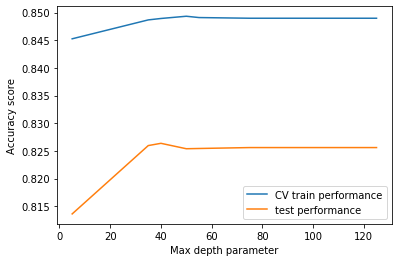

In [87]:
sns.lineplot(x=gs_depth_res['depth'], y=gs_depth_res['mean_test_cv_score'], label="CV train performance")
ax= sns.lineplot(x=gs_depth_res['depth'], y=gs_depth_res['actual_test_score'], label="test performance")
ax.set(xlabel="Max depth parameter", ylabel="Accuracy score")

In [ ]:
print("Train shape:", X_train.shape)
print("Test shape:",  X_test.shape)

In [ ]:
X_train.head()

In [ ]:
model_params = {
    'rseed':229
}

In [9]:
# withou any parameters
clf = lgb.LGBMClassifier(random_state=model_params['rseed'])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

accuracy 0.7451897001472145
              precision    recall  f1-score   support

           0       0.71      0.63      0.66     15514
           1       0.77      0.83      0.80     23205

    accuracy                           0.75     38719
   macro avg       0.74      0.73      0.73     38719
weighted avg       0.74      0.75      0.74     38719

[[ 9699  5815]
 [ 4051 19154]]


In [10]:
# with some params, haven't tuned yet though really
clf = lgb.LGBMClassifier(
    num_leaves = 100, 
    min_data_in_leaf = 50, 
    max_depth = 15, 
    feature_fraction = 0.75, 
    max_bin=200, 
    #learning_rate=0.03,
    lambda_l1=0.75, 
    lambda_l2=0.5,
    random_state=model_params['rseed']
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
accuracy 0.7487280146698003
              precision    recall  f1-score   support

           0       0.71      0.63      0.67     15514
           1       0.77      0.83      0.80     23205

    accuracy                           0.75     38719
   macro avg       0.74      0.73      0.73     38719
weighted avg       0.75      0.75      0.75     38719

[[ 9845  5669]
 [ 4060 19145]]


In [11]:
# add naive bayes preds 
nb_proba_train = np.load("data/res/multi_nb_preds_train.npy")
nb_proba_test = np.load("data/res/multi_nb_preds_test.npy")
X_train_nb = X_train.copy()
X_test_nb = X_test.copy()
X_train_nb['nb_proba'] = nb_proba_train[:, 1]
X_test_nb['nb_proba'] = nb_proba_test[:, 1]

In [12]:
clf = lgb.LGBMClassifier(
    num_leaves = 100, 
    min_data_in_leaf = 50, 
    max_depth = 15, 
    feature_fraction = 0.75, 
    max_bin=200, 
    #learning_rate=0.03,
    lambda_l1=0.75, 
    lambda_l2=0.5,
    random_state=model_params['rseed']
)
clf.fit(X_train_nb, y_train)
y_pred = clf.predict(X_test_nb)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
accuracy 0.7618998424546088
              precision    recall  f1-score   support

           0       0.73      0.65      0.69     15514
           1       0.78      0.84      0.81     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.74      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10122  5392]
 [ 3827 19378]]


In [12]:
w2v_train = np.load("data/res/w2v_Xtrain_avg.npy")
w2v_test = np.load("data/res/w2v_Xtest_avg.npy")
X_train_nb_w2v = pd.concat((X_train_nb, pd.DataFrame(w2v_train)), axis=1)
X_test_nb_w2v = pd.concat((X_test_nb, pd.DataFrame(w2v_test)), axis=1)

In [16]:
clf = lgb.LGBMClassifier(
    num_leaves = 200, 
    min_data_in_leaf = 50, 
    max_depth = 25, 
    feature_fraction = 0.75, 
    max_bin=400, 
    #learning_rate=0.03,
    lambda_l1=0.75, 
    lambda_l2=0.5,
    is_unbalance=True,
    random_state=model_params['rseed']
)
clf.fit(X_train_nb_w2v, y_train)
y_pred = clf.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0.75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
accuracy 0.7623905576073762
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     15514
           1       0.80      0.80      0.80     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.75      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10880  4634]
 [ 4566 18639]]


In [14]:
from sklearn.model_selection import GridSearchCV

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

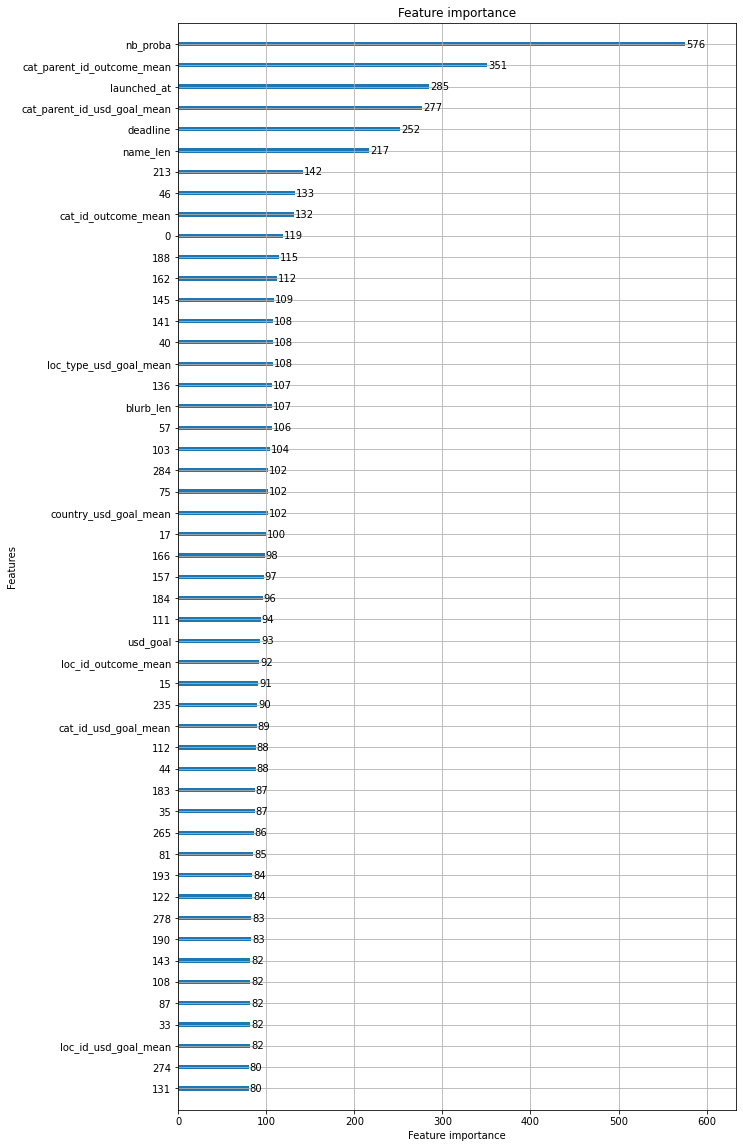

In [18]:
lgb.plot_importance(clf, max_num_features=50, figsize=(10,20))

In [15]:
param_grid = {
    'num_leaves': [200, 400], 
    'max_depth': [15, 35], 
    'feature_fraction':[0.5, 0.75, 1], 
    'bagging_fraction':[0.5, 1],
    #'max_bin':[200, 400], 
    #'lambda_l1':[0.25,  0.75],
    #'lambda_l2':[0.25,  0.75],
    'min_data_in_leaf':[50]
}
# run grid search over parameters using 5 fold CV verbose on 
grid_lgbm = GridSearchCV(lgb.LGBMClassifier(random_state=model_params['rseed'], is_unbalance=True, num_threads=2), param_grid, cv=5, verbose=3, n_jobs=4)
grid_lgbm.fit(X_train_nb_w2v, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


GridSearchCV(cv=5,
             estimator=LGBMClassifier(is_unbalance=True, num_threads=2,
                                      random_state=229),
             n_jobs=4,
             param_grid={'bagging_fraction': [0.5, 1],
                         'feature_fraction': [0.5, 0.75, 1],
                         'max_depth': [15, 35], 'min_data_in_leaf': [50],
                         'num_leaves': [200, 400]},
             verbose=3)

In [18]:
y_pred = grid_lgbm.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

accuracy 0.7611508561688061
              precision    recall  f1-score   support

           0       0.71      0.68      0.70     15514
           1       0.79      0.81      0.80     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.75      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10592  4922]
 [ 4326 18879]]


In [17]:
# best from first
print(grid_lgbm.best_params_)
print(grid_lgbm.best_score_)

{'bagging_fraction': 0.5, 'feature_fraction': 1, 'max_depth': 35, 'min_data_in_leaf': 50, 'num_leaves': 400}
0.8421147889119689


In [21]:
best_params = grid_lgbm.best_params_
new_param_grid={
    'max_bin':[200, 400],
    'lambda_l1':[0.25, 0.5, 0.75],
    'lambda_l2':[0.25, 0.5, 0.75]
}
 # run grid search over parameters using 5 fold CV verbose on 
new_grid_lgbm = GridSearchCV(lgb.LGBMClassifier(random_state=model_params['rseed'], is_unbalance=True, num_threads=2, **best_params), new_param_grid, cv=5, verbose=3, n_jobs=4)
new_grid_lgbm.fit(X_train_nb_w2v, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Unknown parameter: labmda_l1
[LightGBM] [Warning] Unknown parameter: labmda_l2
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


GridSearchCV(cv=5,
             estimator=LGBMClassifier(bagging_fraction=0.5, feature_fraction=1,
                                      is_unbalance=True,
                                      labmda_l1=[0.25, 0.5, 0.75],
                                      labmda_l2=[0.25, 0.5, 0.75],
                                      max_bin=[200, 300, 400], max_depth=35,
                                      min_data_in_leaf=50, num_leaves=400,
                                      num_threads=2, random_state=229),
             n_jobs=4,
             param_grid={'lambda_l1': [0.25, 0.5, 0.75],
                         'lambda_l2': [0.25, 0.5, 0.75],
                         'max_bin': [200, 400]},
             verbose=3)

In [38]:
y_pred = new_grid_lgbm.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

accuracy 0.7602210800898783
              precision    recall  f1-score   support

           0       0.71      0.68      0.70     15514
           1       0.79      0.81      0.80     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.75      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10589  4925]
 [ 4359 18846]]


In [22]:
# best from first
print(new_grid_lgbm.best_params_)
print(new_grid_lgbm.best_score_)

{'lambda_l1': 0.5, 'lambda_l2': 0.5, 'max_bin': 400}
0.8431134511526812


In [34]:
best_params ={**grid_lgbm.best_params_, **new_grid_lgbm.best_params_}

In [43]:
deeper_params = best_params.copy()
deeper_params['num_leaves'] = 600
deeper_params['max_depth'] = 45
#deeper_params['max_bin'] = 500
clf = lgb.LGBMClassifier(
    random_state=model_params['rseed'], 
    is_unbalance=True, 
    **deeper_params
)
clf.fit(X_train_nb_w2v, y_train)
y_pred = clf.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
accuracy 0.7616932255481805
              precision    recall  f1-score   support

           0       0.71      0.68      0.70     15514
           1       0.79      0.82      0.80     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.75      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10527  4987]
 [ 4240 18965]]


In [49]:
from sklearn.linear_model import LinearRegression 
lm = LinearRegression()
lm.fit(X_train_nb_w2v, y_train)
lm_pred = lm.predict(X_train_nb_w2v)
lm_pred_test = lm.predict(X_test_nb_w2v)

In [50]:
X_train_nb_w2v_ols = X_train_nb_w2v.copy()
X_test_nb_w2v_ols = X_test_nb_w2v.copy()
X_train_nb_w2v_ols['ols_pred'] = lm_pred
X_test_nb_w2v_ols['ols_pred'] = lm_pred_test
deeper_params = best_params.copy()
#deeper_params['num_leaves'] = 600
deeper_params['max_depth'] = 45
deeper_params['max_bin'] = 500
clf = lgb.LGBMClassifier(
    random_state=model_params['rseed'], 
    is_unbalance=True, 
    **deeper_params
)
clf.fit(X_train_nb_w2v_ols, y_train)
y_pred = clf.predict(X_test_nb_w2v_ols)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
accuracy 0.7601694258632713
              precision    recall  f1-score   support

           0       0.71      0.68      0.69     15514
           1       0.79      0.81      0.80     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.75      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10544  4970]
 [ 4316 18889]]


In [44]:
deeper_params = best_params.copy()
#deeper_params['num_leaves'] = 600
deeper_params['max_depth'] = 45
deeper_params['max_bin'] = 500
clf = lgb.LGBMClassifier(
    random_state=model_params['rseed'], 
    is_unbalance=True, 
    **deeper_params
)
clf.fit(X_train_nb_w2v, y_train)
y_pred = clf.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
accuracy 0.7614866086417521
              precision    recall  f1-score   support

           0       0.71      0.69      0.70     15514
           1       0.79      0.81      0.80     23205

    accuracy                           0.76     38719
   macro avg       0.75      0.75      0.75     38719
weighted avg       0.76      0.76      0.76     38719

[[10658  4856]
 [ 4379 18826]]


In [13]:
clf = lgb.LGBMClassifier(
    random_state=model_params['rseed'], 
    is_unbalance=True, 
    bagging_fraction=0.5, 
    feature_fraction=0.2, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb_w2v, y_train)
y_pred = clf.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
accuracy 0.7673235362483535
              precision    recall  f1-score   support

           0       0.72      0.70      0.71     15514
           1       0.80      0.81      0.81     23205

    accuracy                           0.77     38719
   macro avg       0.76      0.76      0.76     38719
weighted avg       0.77      0.77      0.77     38719

[[10813  4701]
 [ 4308 18897]]


In [14]:
from pdpbox import pdp, get_dataset, info_plots
from matplotlib import pyplot as plt

In [16]:
X_train_nb_w2v.columns

Index([                 'blurb_len',                   'name_len',
                         'usd_goal',                   'deadline',
                      'launched_at',      'currency_outcome_mean',
             'country_outcome_mean',        'cat_id_outcome_mean',
       'cat_parent_id_outcome_mean',        'loc_id_outcome_mean',
       ...
                                290,                          291,
                                292,                          293,
                                294,                          295,
                                296,                          297,
                                298,                          299],
      dtype='object', length=318)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8768693820>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8768666ee0>})

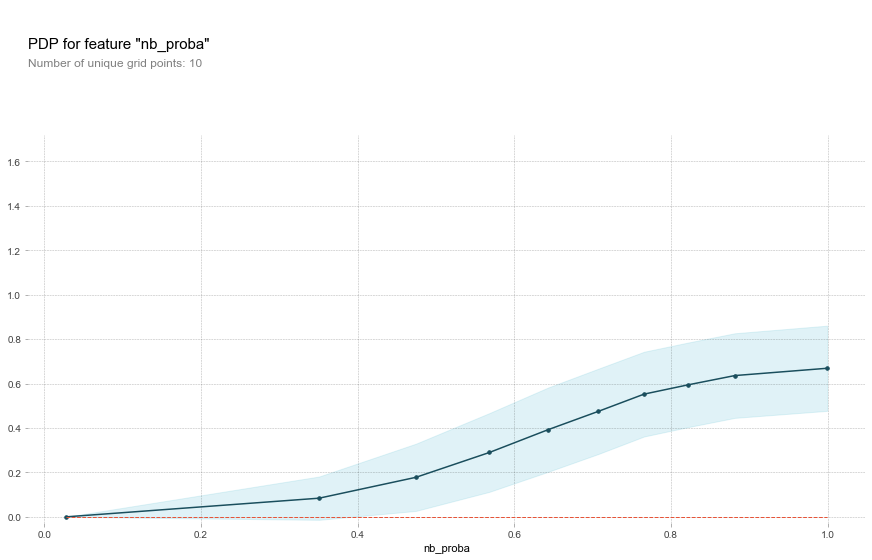

In [15]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_train_nb_w2v, model_features=X_train_nb_w2v.columns, feature='nb_proba')

# plot it
pdp.pdp_plot(pdp_goals, 'nb_proba')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f872636f6d0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8726103cd0>})

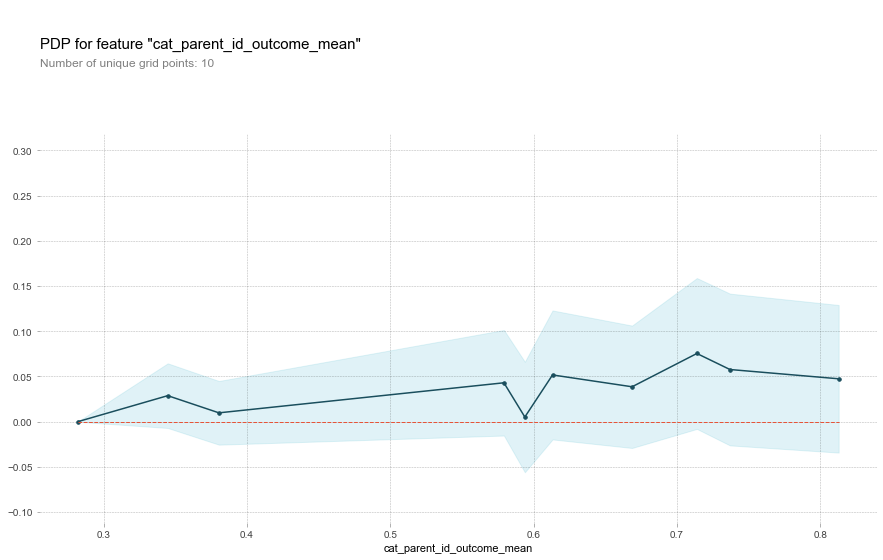

In [17]:
pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_train_nb_w2v, model_features=X_train_nb_w2v.columns, feature='cat_parent_id_outcome_mean')

# plot it
pdp.pdp_plot(pdp_goals, 'cat_parent_id_outcome_mean')

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f872635b760>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8705fb6160>})

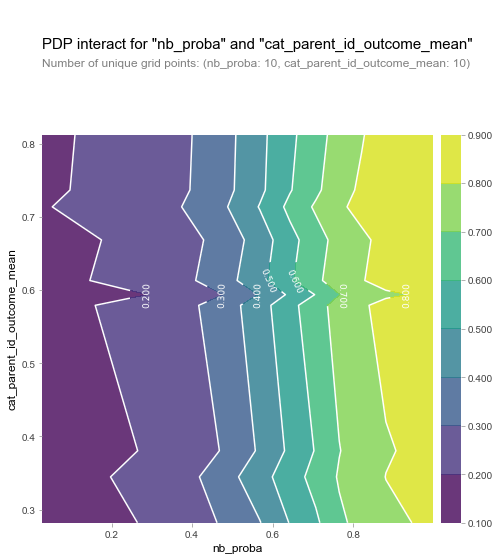

In [18]:
features_to_plot = ['nb_proba', 'cat_parent_id_outcome_mean']
inter1  =  pdp.pdp_interact(model=clf, dataset=X_train_nb_w2v, model_features=X_train_nb_w2v.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')